In [1]:
# Task:
# determine whether a person makes over 50K a year.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.dummy import DummyClassifier
from statistics import mean
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, RepeatedEditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.pipeline import Pipeline
#from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [3]:
names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'label']
df = pd.read_csv('datasets/adult.csv', names=names)

In [4]:
df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
def clean(df):
  # drop samle with ' ?' in it
  df = df[(df['workclass'] != ' ?')]
  df = df[(df['occupation'] != ' ?')]
  df = df[(df['native_country'] != ' ?')]
  return df

def encode(df, col_names):
  tmp = df.copy()
  for col_name in col_names:
    if col_name == 'label':
      a = tmp[col_name].values
      lb = LabelBinarizer()
      a = lb.fit_transform(a)
      tmp[col_name] = a.astype('int32')
      
    b = tmp[col_name].values
    encoder = OrdinalEncoder()
    b = encoder.fit_transform(b.reshape(-1,1))
    tmp[col_name] = b
  return tmp

def seperate_xy(tmp):
  x = tmp.values[:,:-1]
  y = tmp.values[:,-1]
  return x, y

def f2_measure(y, pred):
  return fbeta_score(y, pred, beta=2)

def eval_model(x, y, model):
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  metric = make_scorer(f2_measure)
  scores = cross_val_score(model, x, y, scoring=metric, cv=cv)
  return scores

def get_models():
  models = []
  models.append(('TL', TomekLinks()))
  models.append(('ENN', EditedNearestNeighbours()))
  models.append(('RENN', RepeatedEditedNearestNeighbours()))
  models.append(('OSS', OneSidedSelection()))
  models.append(('NCR', NeighbourhoodCleaningRule()))
  return models

In [6]:
col_names = ['label', 'workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
dff = clean(df)
tmp = encode(dff, col_names)
x, y = seperate_xy(tmp)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
# Baseline Result 
model = DummyClassifier(strategy='constant', constant=1)
scores = eval_model(x_train, y_train, model)
print(f"Mean F2: {mean(scores):.3f}")

Mean F2: 0.622


In [8]:
models = get_models()
names, results = [], []
for name, model in models:
  #lr = LogisticRegression(solver='liblinear', class_weight='balanced')
  lr = XGBClassifier(learning_rate=0.1)
  pipeline = Pipeline([
    (name, model),
    ('LR', lr)
  ])
  
  scores = eval_model(x_train, y_train, pipeline)
  results.append(scores)
  names.append(name)
  print(f"{name}: {mean(scores):.3f}")

TL: 0.708
ENN: 0.773
RENN: 0.786
OSS: 0.707
NCR: 0.770


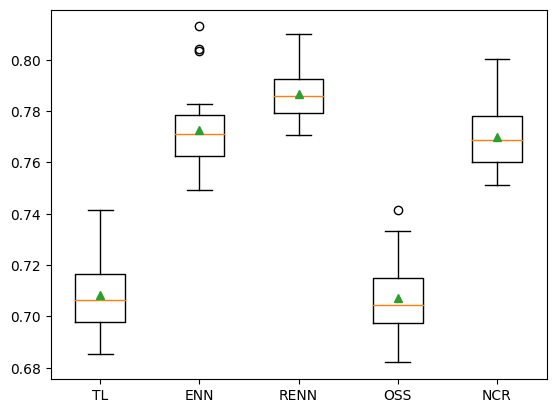

In [9]:
plt.boxplot(results, labels=names, showmeans=True);

In [10]:
# Fit model and make prediction
from sklearn.metrics import classification_report

In [14]:
#lr = LogisticRegression(solver='liblinear', class_weight='balanced')
model = XGBClassifier(learning_rate=0.1)
pipeline = Pipeline([
    ('ENN', EditedNearestNeighbours()),
    ('XGB', model)
])

pipeline.fit(x_train, y_train)

Pipeline(steps=[('ENN', EditedNearestNeighbours()),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [15]:
train_result = pipeline.predict(x_train)
print(classification_report(y_train, train_result))

              precision    recall  f1-score   support

         0.0       0.95      0.86      0.90     18151
         1.0       0.66      0.85      0.74      5978

    accuracy                           0.86     24129
   macro avg       0.80      0.85      0.82     24129
weighted avg       0.88      0.86      0.86     24129



In [16]:
test_result = pipeline.predict(x_test)
print(classification_report(y_test, test_result))

              precision    recall  f1-score   support

         0.0       0.93      0.85      0.89      4503
         1.0       0.65      0.83      0.73      1530

    accuracy                           0.84      6033
   macro avg       0.79      0.84      0.81      6033
weighted avg       0.86      0.84      0.85      6033

